# Visualise what is going on!

In [56]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import (add_self_loops, sort_edge_index,
                                   remove_self_loops)
from torch_sparse import spspmm
from net.braingraphconv import MyNNConv
import os
import numpy as np
import time
import copy
import torch
import torch.nn.functional as F
from torch.optim import lr_scheduler
from tensorboardX import SummaryWriter
from imports_data.ABIDEDataset import ABIDEDataset
from torch_geometric.data import DataLoader
from net.braingnn import Network
from imports_data.utils import train_val_test_split
from sklearn.metrics import classification_report, confusion_matrix

The network we have:

In [57]:
class Network(torch.nn.Module):
    def __init__(self, indim, ratio, nclass, k=8, R=200):
        '''

        :param indim: (int) node feature dimension
        :param ratio: (float) pooling ratio in (0,1)
        :param nclass: (int)  number of classes
        :param k: (int) number of communities
        :param R: (int) number of ROIs
        '''
        super(Network, self).__init__()

        self.indim = indim
        self.dim1 = 32
        self.dim2 = 32
        self.dim3 = 512
        self.dim4 = 256
        self.dim5 = 8
        self.k = k
        self.R = R

        self.n1 = nn.Sequential(nn.Linear(self.R, self.k, bias=False), nn.ReLU(), nn.Linear(self.k, self.dim1 * self.indim))
        self.conv1 = MyNNConv(self.indim, self.dim1, self.n1, normalize=False)
        self.pool1 = TopKPooling(self.dim1, ratio=ratio, multiplier=1, nonlinearity=torch.sigmoid)
        self.n2 = nn.Sequential(nn.Linear(self.R, self.k, bias=False), nn.ReLU(), nn.Linear(self.k, self.dim2 * self.dim1))
        self.conv2 = MyNNConv(self.dim1, self.dim2, self.n2, normalize=False)
        self.pool2 = TopKPooling(self.dim2, ratio=ratio, multiplier=1, nonlinearity=torch.sigmoid)


        self.fc1 = torch.nn.Linear((self.dim1+self.dim2)*2, self.dim2)
        self.bn1 = torch.nn.BatchNorm1d(self.dim2)
        self.fc2 = torch.nn.Linear(self.dim2, self.dim3)
        self.bn2 = torch.nn.BatchNorm1d(self.dim3)
        self.fc3 = torch.nn.Linear(self.dim3, nclass)




    def forward(self, x, edge_index, batch, edge_attr, pos):

        x = self.conv1(x, edge_index, edge_attr, pos)
        x, edge_index, edge_attr, batch, perm, score1 = self.pool1(x, edge_index, edge_attr, batch)

        pos = pos[perm]
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        edge_attr = edge_attr.squeeze()
        edge_index, edge_attr = self.augment_adj(edge_index, edge_attr, x.size(0))

        x = self.conv2(x, edge_index, edge_attr, pos)
        x, edge_index, edge_attr, batch, perm, score2 = self.pool2(x, edge_index,edge_attr, batch)

        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = torch.cat([x1,x2], dim=1)
        x = self.bn1(F.relu(self.fc1(x)))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.bn2(F.relu(self.fc2(x)))
        x= F.dropout(x, p=0.5, training=self.training)
        x = F.log_softmax(self.fc3(x), dim=-1)

        return x,self.pool1.weight,self.pool2.weight, torch.sigmoid(score1).view(x.size(0),-1), torch.sigmoid(score2).view(x.size(0),-1), perm

    def augment_adj(self, edge_index, edge_weight, num_nodes):
        edge_index, edge_weight = add_self_loops(edge_index, edge_weight,
                                                 num_nodes=num_nodes)
        edge_index, edge_weight = sort_edge_index(edge_index, edge_weight,
                                                  num_nodes)
        edge_index, edge_weight = spspmm(edge_index, edge_weight, edge_index,
                                         edge_weight, num_nodes, num_nodes,
                                         num_nodes)
        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
        return edge_index, edge_weight



In [58]:
batchSize = 100
# feature dim
indim = 200
#num of rio
nroi = 200
# num of classes
nclass = 2
ratio = 0.5

load the dataset :

In [59]:
# root directory of the dataset
name = 'ABIDE'
dataroot = 'D:\EE\ETH\project\BrainGNN\data\ABIDE_pcp\cpac\\filt_noglobal'

In [60]:
dataset = ABIDEDataset(dataroot, name)
dataset.data.y = dataset.data.y.squeeze()
print(len(dataset))
dataset.data.x[dataset.data.x == float('inf')] = 0
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)


1035


C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\data\in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
C:\Users\MehrSystem\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


load the model:

In [61]:
model = Network(indim, ratio, nclass)
model.load_state_dict(torch.load("D:\EE\ETH\project\BrainGNN\Model\\1.pth"))
model.eval()

Network(
  (n1): Sequential(
    (0): Linear(in_features=200, out_features=8, bias=False)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=6400, bias=True)
  )
  (conv1): MyNNConv(200, 32)
  (pool1): TopKPooling(32, ratio=0.5, multiplier=1)
  (n2): Sequential(
    (0): Linear(in_features=200, out_features=8, bias=False)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1024, bias=True)
  )
  (conv2): MyNNConv(32, 32)
  (pool2): TopKPooling(32, ratio=0.5, multiplier=1)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)

In [64]:
nodes_HC = []
nods_ASD = []
for data in data_loader:
    output, w1, w2, s1, s2, perm = model(data.x, data.edge_index, data.batch, data.edge_attr, data.pos)
    if data.y.numpy() == 0:
        nodes_HC = nodes_HC + list(perm)
    else:
        nods_ASD = nods_ASD + list(perm)
print(nods_ASD)

[tensor(66), tensor(95), tensor(37), tensor(50), tensor(2), tensor(32), tensor(54), tensor(80), tensor(70), tensor(29), tensor(6), tensor(89), tensor(67), tensor(20), tensor(46), tensor(85), tensor(24), tensor(56), tensor(14), tensor(63), tensor(4), tensor(40), tensor(64), tensor(88), tensor(77), tensor(78), tensor(30), tensor(57), tensor(72), tensor(7), tensor(28), tensor(59), tensor(53), tensor(35), tensor(44), tensor(43), tensor(49), tensor(34), tensor(51), tensor(0), tensor(98), tensor(68), tensor(38), tensor(45), tensor(21), tensor(74), tensor(60), tensor(25), tensor(92), tensor(71), tensor(45), tensor(60), tensor(97), tensor(69), tensor(78), tensor(98), tensor(82), tensor(21), tensor(24), tensor(40), tensor(39), tensor(26), tensor(84), tensor(58), tensor(14), tensor(91), tensor(22), tensor(75), tensor(53), tensor(95), tensor(63), tensor(27), tensor(88), tensor(83), tensor(76), tensor(50), tensor(72), tensor(15), tensor(62), tensor(48), tensor(56), tensor(37), tensor(96), tensor(2

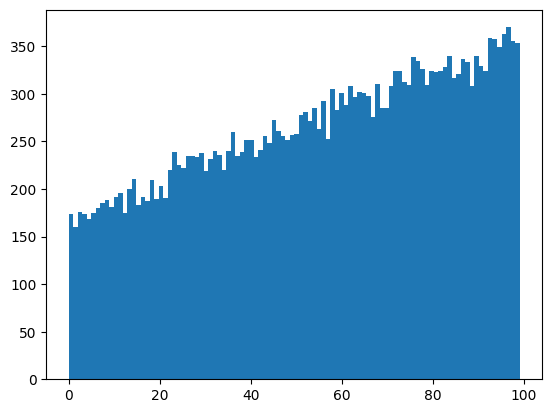

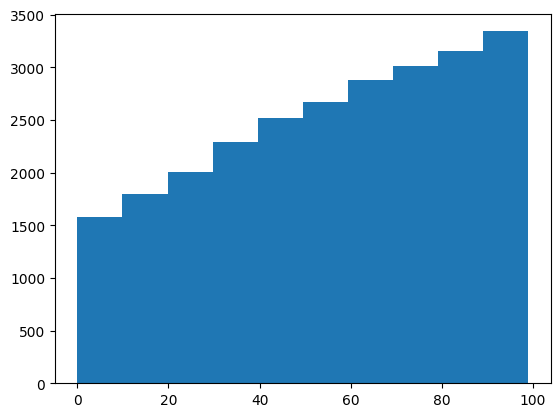

In [65]:
import matplotlib.pyplot as plt
plt.hist(nodes_HC, bins = 100)
plt.show()
plt.hist(nods_ASD, bins=100)
plt.show()